In [3]:
import dgl
from dgl.nn import GraphConv
from pyvis.network import Network
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
epochs = 100

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Extracting file to C:\Users\rabgu\.dgl\cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [4]:
g_vis = Network(height=800, width=800, notebook=True)

netxG = nx.Graph(g.to_networkx())

mapping = {i:i for i in range(netxG.size())} #Setting mapping for the relabeling
netxH = nx.relabel_nodes(netxG,mapping) #relabeling nodes

g_vis.from_nx(netxH)
g_vis.show('visual.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [5]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [6]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    trainaccall = []
    testaccall = []
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(epochs):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        trainaccall.append(train_acc)
        testaccall.append(test_acc)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    return trainaccall, testaccall
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
trainaccall, testaccall = train(g, model)

In epoch 0, loss: 1.946, val acc: 0.218 (best 0.218), test acc: 0.201 (best 0.201)
In epoch 5, loss: 1.897, val acc: 0.494 (best 0.522), test acc: 0.517 (best 0.555)
In epoch 10, loss: 1.818, val acc: 0.560 (best 0.560), test acc: 0.587 (best 0.587)
In epoch 15, loss: 1.716, val acc: 0.578 (best 0.578), test acc: 0.594 (best 0.594)
In epoch 20, loss: 1.591, val acc: 0.654 (best 0.654), test acc: 0.650 (best 0.650)
In epoch 25, loss: 1.447, val acc: 0.688 (best 0.690), test acc: 0.686 (best 0.685)
In epoch 30, loss: 1.289, val acc: 0.704 (best 0.704), test acc: 0.689 (best 0.689)
In epoch 35, loss: 1.125, val acc: 0.714 (best 0.714), test acc: 0.713 (best 0.706)
In epoch 40, loss: 0.961, val acc: 0.720 (best 0.720), test acc: 0.736 (best 0.736)
In epoch 45, loss: 0.805, val acc: 0.726 (best 0.726), test acc: 0.742 (best 0.742)
In epoch 50, loss: 0.663, val acc: 0.736 (best 0.736), test acc: 0.751 (best 0.751)
In epoch 55, loss: 0.539, val acc: 0.738 (best 0.738), test acc: 0.759 (best 0

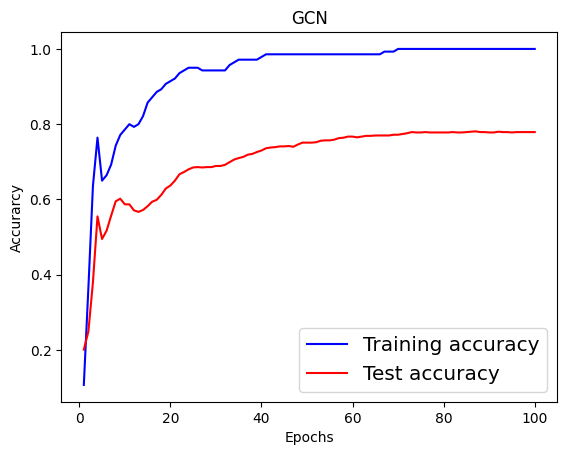

In [7]:
plt.plot(np.arange(1,epochs+1),trainaccall, label='Training accuracy', c='blue')
plt.plot(np.arange(1,epochs+1),testaccall, label='Test accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GCN')
plt.legend(loc='lower right', fontsize='x-large')
plt.show()